In [3]:
import shutil
import os
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


In [4]:
# load the stock dataset
path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\Menuja Minu\.cache\kagglehub\datasets\rahulsah06\gooogle-stock-price\versions\1
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


In [4]:
# load the stock_train CSV file into a pandas DataFrame
stock_train_df = pd.read_csv("Google_Stock_Price_Train.csv")
stock_train_df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
# Check data types to identify object fields
print(stock_train_df.dtypes)


Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object


In [6]:
#turn Close field into numeric field
stock_train_df['Close'] = pd.to_numeric(stock_train_df['Close'].str.replace(',', ''), errors='coerce')

# turn Volume field into numeric field and remove commas 
stock_train_df['Volume'] = stock_train_df['Volume'].str.replace(',', '').astype(int)

# Check for missing values or conversion issues
print(stock_train_df.isnull().sum())

# Display the first few rows to confirm changes
print(stock_train_df.head())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
       Date    Open    High     Low   Close    Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7380500
1  1/4/2012  331.27  333.87  329.08  666.45   5749400
2  1/5/2012  329.83  330.75  326.89  657.21   6590300
3  1/6/2012  328.34  328.77  323.68  648.24   5405900
4  1/9/2012  322.04  322.29  309.46  620.76  11688800


In [7]:
# Ensure 'Date' column is in datetime format
stock_train_df['Date'] = pd.to_datetime(stock_train_df['Date'], format='%m/%d/%Y')

# Extract the quarter and add it as a new column
stock_train_df['Quarter'] = stock_train_df['Date'].dt.quarter

stock_train_df['Close'] = stock_train_df.apply(lambda row: row['Close'] / 2 if row['Close'] > row['High'] else row['Close'], axis=1)

# Display the first few rows to confirm the changes
print(stock_train_df.head())


        Date    Open    High     Low    Close    Volume  Quarter
0 2012-01-03  325.25  332.83  324.97  331.795   7380500        1
1 2012-01-04  331.27  333.87  329.08  333.225   5749400        1
2 2012-01-05  329.83  330.75  326.89  328.605   6590300        1
3 2012-01-06  328.34  328.77  323.68  324.120   5405900        1
4 2012-01-09  322.04  322.29  309.46  310.380  11688800        1


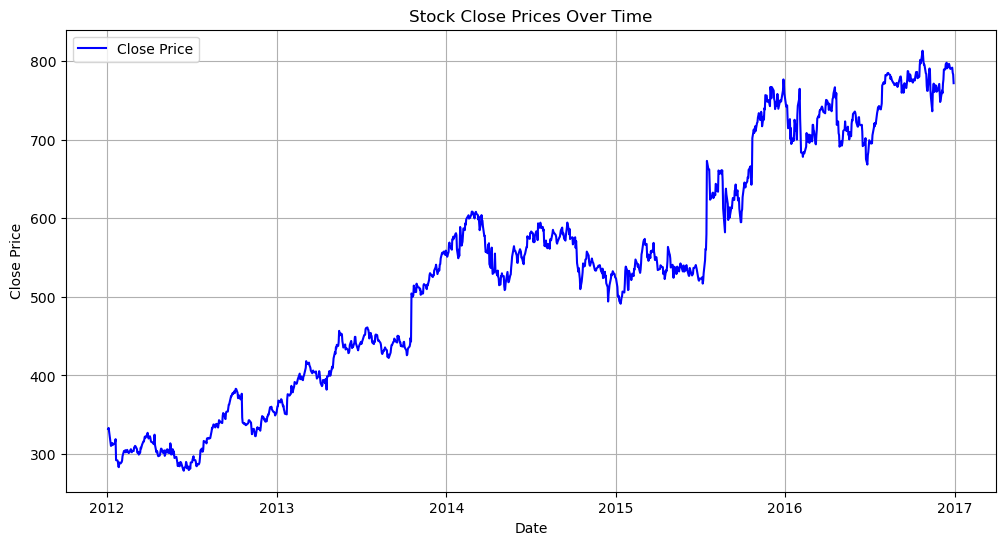

In [8]:
# Plot Close prices over time
plt.figure(figsize=(12, 6))
plt.plot(stock_train_df['Date'], stock_train_df['Close'], label='Close Price', color='blue')
plt.title('Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Menuja Minu\AppData\Local\Temp\ipykernel_22756\3108440871.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quarter', y='Close', data=avg_close_by_quarter, palette='coolwarm')


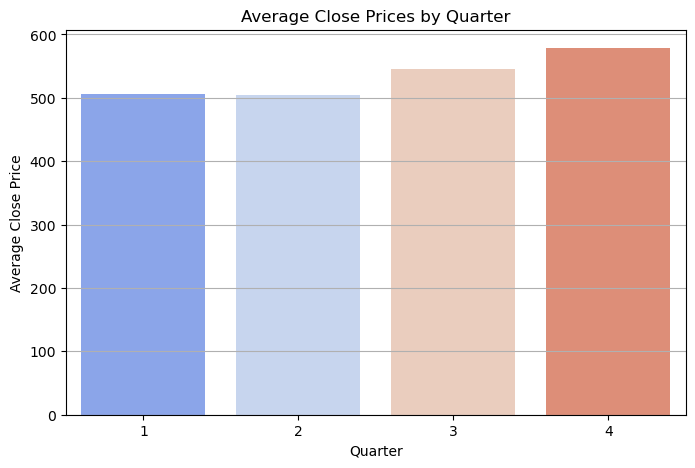

In [9]:
# Calculate average Close prices per quarter
avg_close_by_quarter = stock_train_df.groupby('Quarter')['Close'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Quarter', y='Close', data=avg_close_by_quarter, palette='coolwarm')
plt.title('Average Close Prices by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.grid(axis='y')
plt.show()

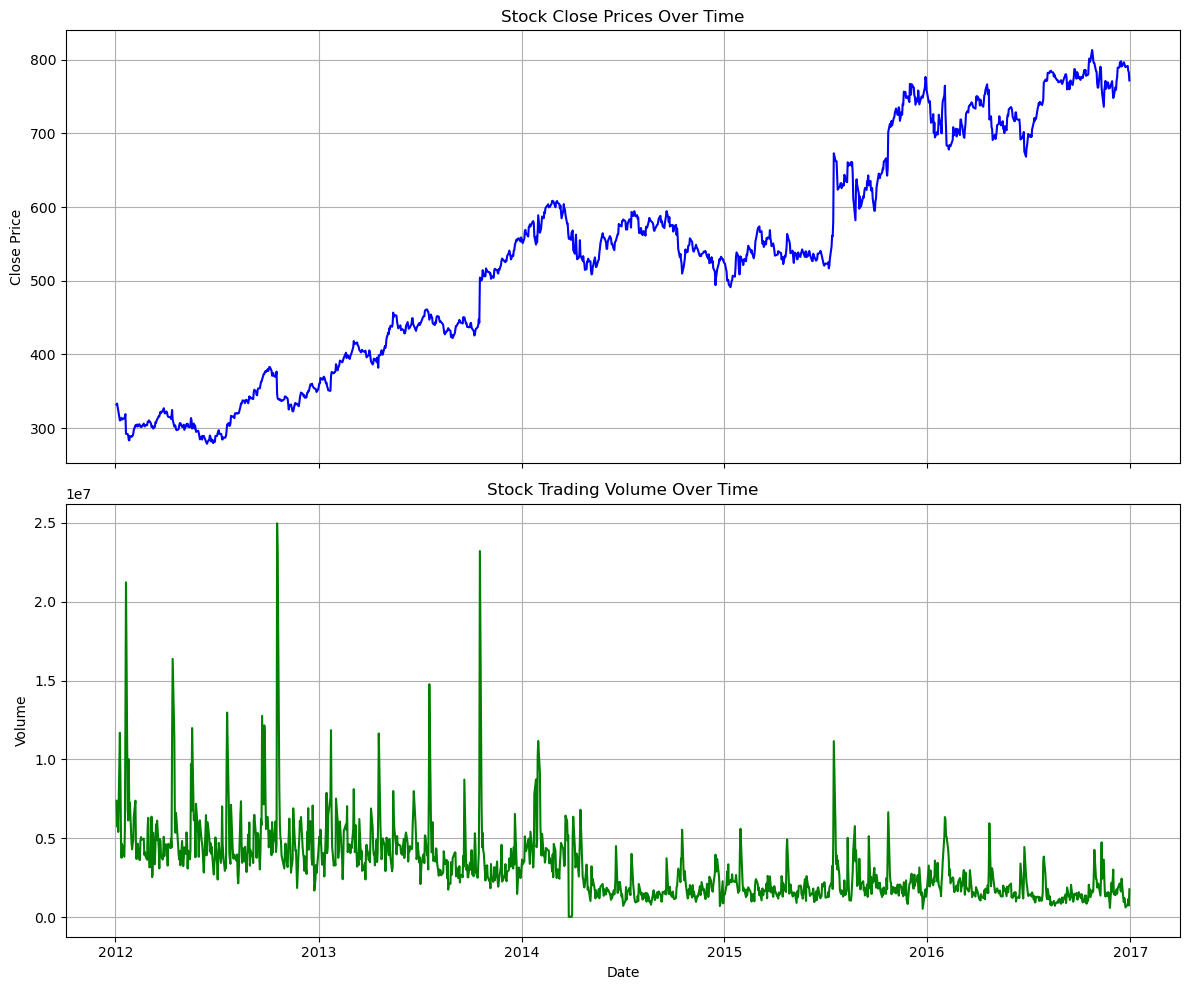

In [10]:
# Create subplots for Close Price and Volume
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Line plot for Close prices
ax[0].plot(stock_train_df['Date'], stock_train_df['Close'], color='blue')
ax[0].set_title('Stock Close Prices Over Time')
ax[0].set_ylabel('Close Price')
ax[0].grid(True)

# Line plot for Volume
ax[1].plot(stock_train_df['Date'], stock_train_df['Volume'], color='green')
ax[1].set_title('Stock Trading Volume Over Time')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume')
ax[1].grid(True)

plt.tight_layout()
plt.show()

6/6 [==============================] - 0s 29ms/step - loss: 5.2287e-04 - root_mean_squared_error: 0.0229
Test Loss: 0.0005228712689131498, RMSE: 0.022866379469633102
6/6 [==============================] - 0s 32ms/step


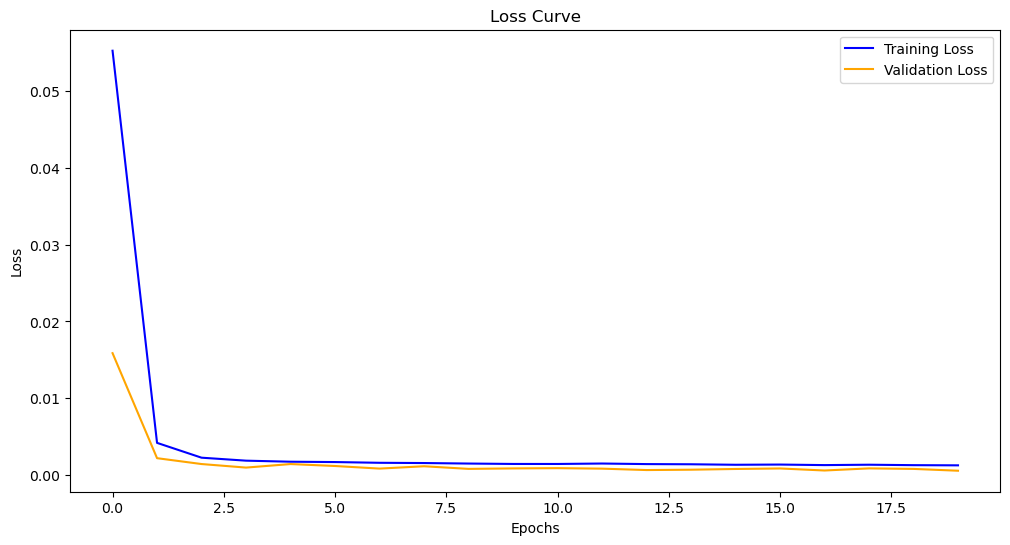

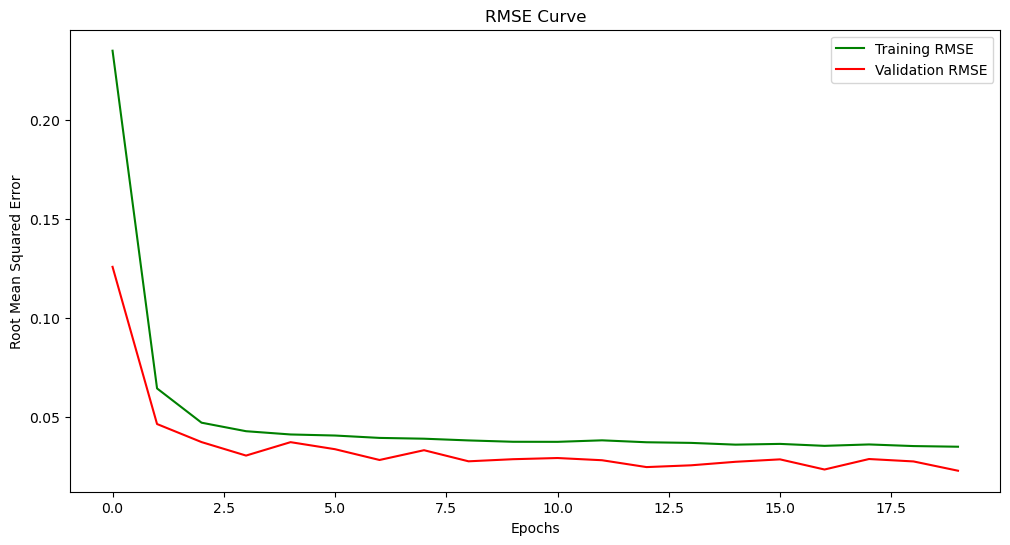

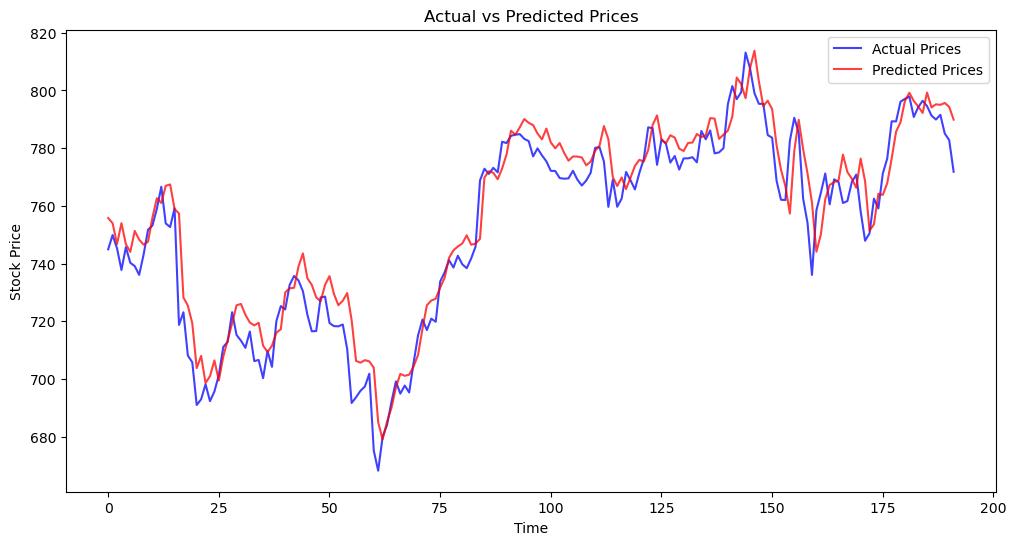

In [33]:
# loading the stock_test dataset
data = stock_train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 60  # Use the last 60 days to predict the next day
x, y = create_sequences(scaled_data, sequence_length)

split_index = int(len(data) * 0.8)

# Split the array
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


# Build the vanilla RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='tanh', input_shape=(x_train.shape[1], 5)),
    tf.keras.layers.Dense(5)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test),verbose=0)

# Evaluate the model
loss,rmse = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, RMSE: {rmse}')

# Make predictions
predictions = model.predict(x_test)

# Rescale predictions back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE curve
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Training RMSE', color='green')
plt.plot(val_rmse, label='Validation RMSE', color='red')
plt.title('RMSE Curve')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

7/7 [==============================] - 0s 13ms/step - loss: 5.9572e-04 - root_mean_squared_error: 0.0244
Test Loss: 0.0005957233370281756, RMSE: 0.024407442659139633
7/7 [==============================] - 0s 19ms/step


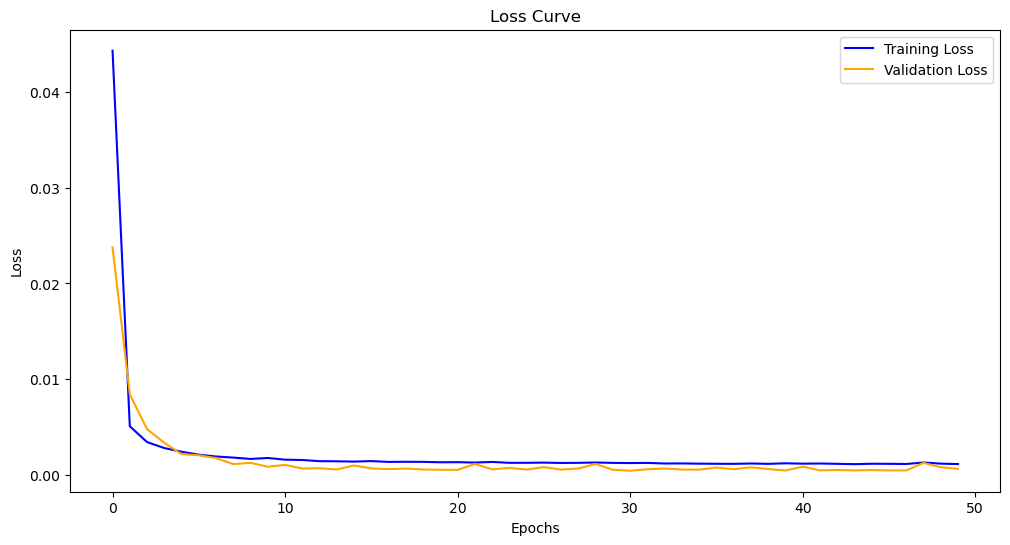

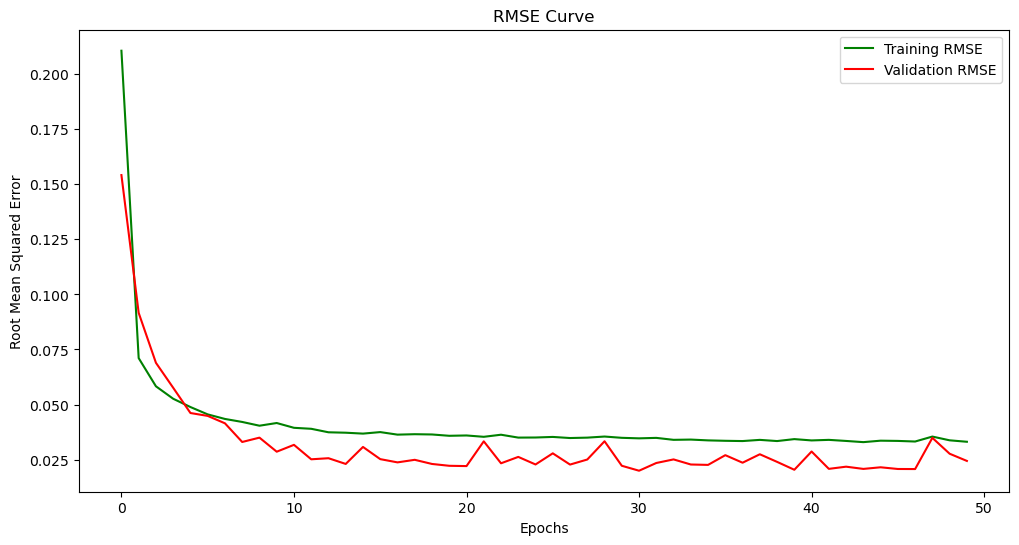

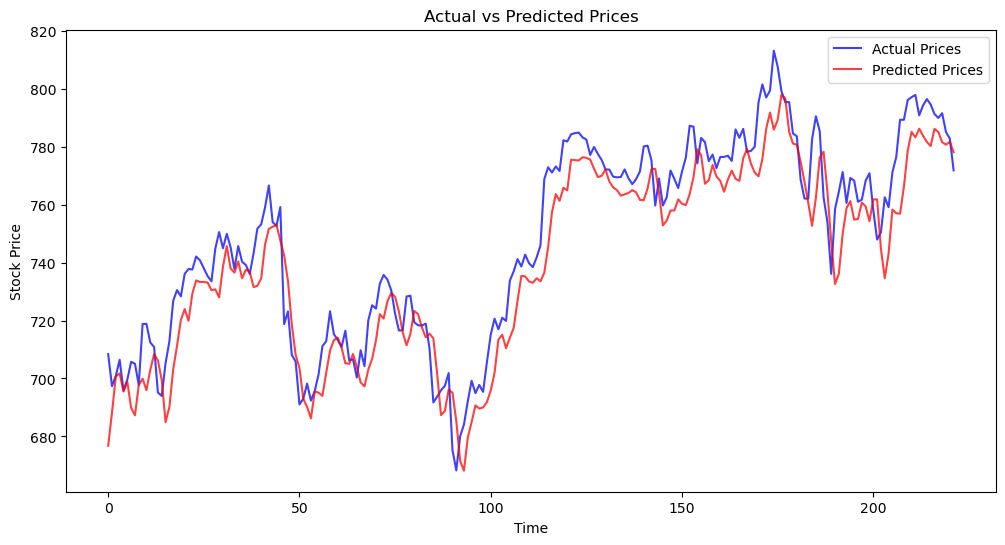

In [35]:
# loading the stock_test dataset
data = stock_train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  # Use the last 60 days to predict the next day
x, y = create_sequences(scaled_data, sequence_length)

split_index = int(len(data) * 0.8)

# Split the array
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


# Build the vanilla RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='tanh', input_shape=(x_train.shape[1], 5)),
    tf.keras.layers.Dense(5)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test),verbose=0)

# Evaluate the model
loss,rmse = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, RMSE: {rmse}')

# Make predictions
predictions = model.predict(x_test)

# Rescale predictions back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE curve
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Training RMSE', color='green')
plt.plot(val_rmse, label='Validation RMSE', color='red')
plt.title('RMSE Curve')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

5/5 [==============================] - 0s 36ms/step - loss: 3.7359e-04 - root_mean_squared_error: 0.0193
Test Loss: 0.00037358791450969875, RMSE: 0.019328422844409943
5/5 [==============================] - 0s 33ms/step


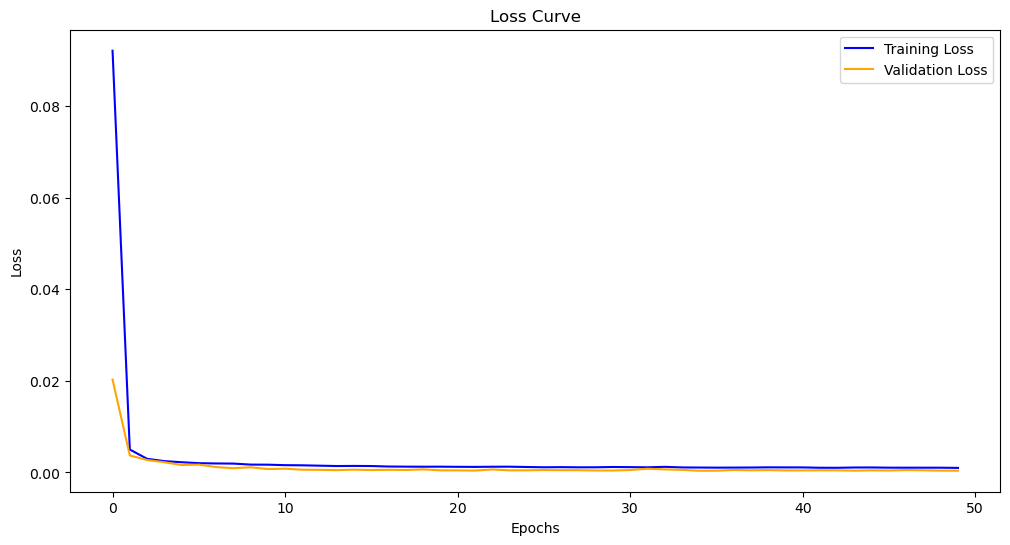

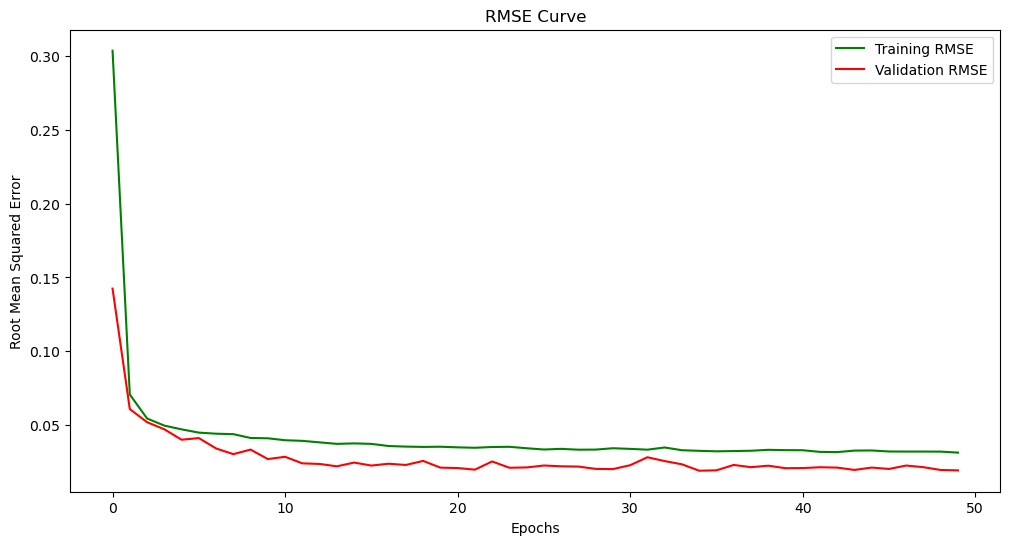

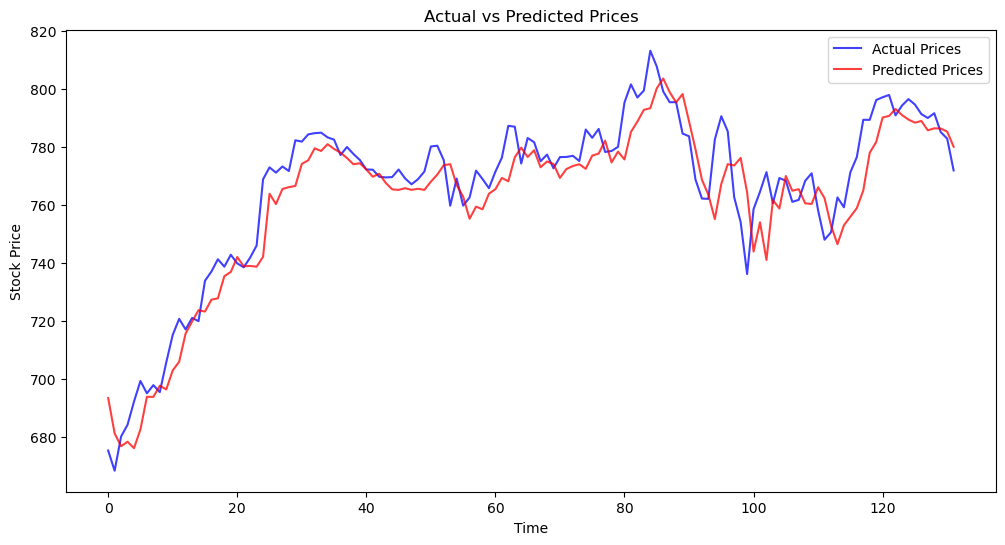

In [36]:
# loading the stock_test dataset
data = stock_train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 120  # Use the last 60 days to predict the next day
x, y = create_sequences(scaled_data, sequence_length)

split_index = int(len(data) * 0.8)

# Split the array
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


# Build the vanilla RNN model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='tanh', input_shape=(x_train.shape[1], 5)),
    tf.keras.layers.Dense(5)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test),verbose=0)

# Evaluate the model
loss,rmse = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, RMSE: {rmse}')

# Make predictions
predictions = model.predict(x_test)

# Rescale predictions back to original scale
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE curve
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Training RMSE', color='green')
plt.plot(val_rmse, label='Validation RMSE', color='red')
plt.title('RMSE Curve')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [25]:
# loading the stock_test dataset
data = stock_train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  
x, y = create_sequences(scaled_data, sequence_length)

split_index = int(len(data) * 0.8)

# Split the array
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

# Build the LSTM model
model = Sequential([
        LSTM(64, activation='tanh', return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(5)  
    ])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test),verbose=0)

# Evaluate the model
loss,rmse = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, RMSE:{rmse}')

# Make predictions
predictions = model.predict(x_test)

# Rescale predictions back to original scale
one_layer_predictions_rescaled = scaler.inverse_transform(predictions)
one_layer_y_test_rescaled = scaler.inverse_transform(y_test)

one_layer_train_loss = history.history['loss']
one_layer_val_loss = history.history['val_loss']
one_layer_train_rmse = history.history['root_mean_squared_error']
one_layer_val_rmse = history.history['val_root_mean_squared_error']
'''
# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE curve
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Training RMSE', color='green')
plt.plot(val_rmse, label='Validation RMSE', color='red')
plt.title('RMSE Curve')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()'''

7/7 [==============================] - 0s 9ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367
Test Loss: 0.0013433638960123062, RMSE:0.03665192797780037
7/7 [==============================] - 1s 10ms/step


"\n# Plot loss curve\nplt.figure(figsize=(12, 6))\nplt.plot(train_loss, label='Training Loss', color='blue')\nplt.plot(val_loss, label='Validation Loss', color='orange')\nplt.title('Loss Curve')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\n\n# Plot RMSE curve\nplt.figure(figsize=(12, 6))\nplt.plot(train_rmse, label='Training RMSE', color='green')\nplt.plot(val_rmse, label='Validation RMSE', color='red')\nplt.title('RMSE Curve')\nplt.xlabel('Epochs')\nplt.ylabel('Root Mean Squared Error')\nplt.legend()\nplt.show()\n\nplt.figure(figsize=(12, 6))\nplt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)\nplt.plot(predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)\nplt.title('Actual vs Predicted Prices')\nplt.xlabel('Time')\nplt.ylabel('Stock Price')\nplt.legend()\nplt.show()"

In [26]:
# loading the stock_test dataset
data = stock_train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  
x, y = create_sequences(scaled_data, sequence_length)

split_index = int(len(data) * 0.8)

# Split the array
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

model = Sequential([
       LSTM(64, return_sequences=True, input_shape=(sequence_length, x.shape[2])),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(30, activation='relu'),
        Dense(5)  
    ])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test),verbose=0)

# Evaluate the model
loss,rmse = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, RMSE:{rmse}')

# Make predictions
predictions = model.predict(x_test)

# Rescale predictions back to original scale
two_layer_predictions_rescaled = scaler.inverse_transform(predictions)
two_layer_y_test_rescaled = scaler.inverse_transform(y_test)

two_layer_train_loss = history.history['loss']
two_layer_val_loss = history.history['val_loss']
two_layer_train_rmse = history.history['root_mean_squared_error']
two_layer_val_rmse = history.history['val_root_mean_squared_error']
'''
# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE curve
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Training RMSE', color='green')
plt.plot(val_rmse, label='Validation RMSE', color='red')
plt.title('RMSE Curve')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()'''

7/7 [==============================] - 0s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494
Test Loss: 0.002442000200971961, RMSE:0.04941659793257713
7/7 [==============================] - 1s 20ms/step


"\n# Plot loss curve\nplt.figure(figsize=(12, 6))\nplt.plot(train_loss, label='Training Loss', color='blue')\nplt.plot(val_loss, label='Validation Loss', color='orange')\nplt.title('Loss Curve')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\n\n# Plot RMSE curve\nplt.figure(figsize=(12, 6))\nplt.plot(train_rmse, label='Training RMSE', color='green')\nplt.plot(val_rmse, label='Validation RMSE', color='red')\nplt.title('RMSE Curve')\nplt.xlabel('Epochs')\nplt.ylabel('Root Mean Squared Error')\nplt.legend()\nplt.show()\n\nplt.figure(figsize=(12, 6))\nplt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)\nplt.plot(predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)\nplt.title('Actual vs Predicted Prices')\nplt.xlabel('Time')\nplt.ylabel('Stock Price')\nplt.legend()\nplt.show()"

Epoch 1/50
32/32 [==============================] - 13s 201ms/step - loss: 0.0392 - root_mean_squared_error: 0.1981 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 2/50
32/32 [==============================] - 5s 173ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 3/50
32/32 [==============================] - 5s 157ms/step - loss: 0.0060 - root_mean_squared_error: 0.0778 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 4/50
32/32 [==============================] - 5s 168ms/step - loss: 0.0051 - root_mean_squared_error: 0.0716 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 5/50
32/32 [==============================] - 5s 159ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 6/50
32/32 [==============================] - 5s 166ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0049 - val

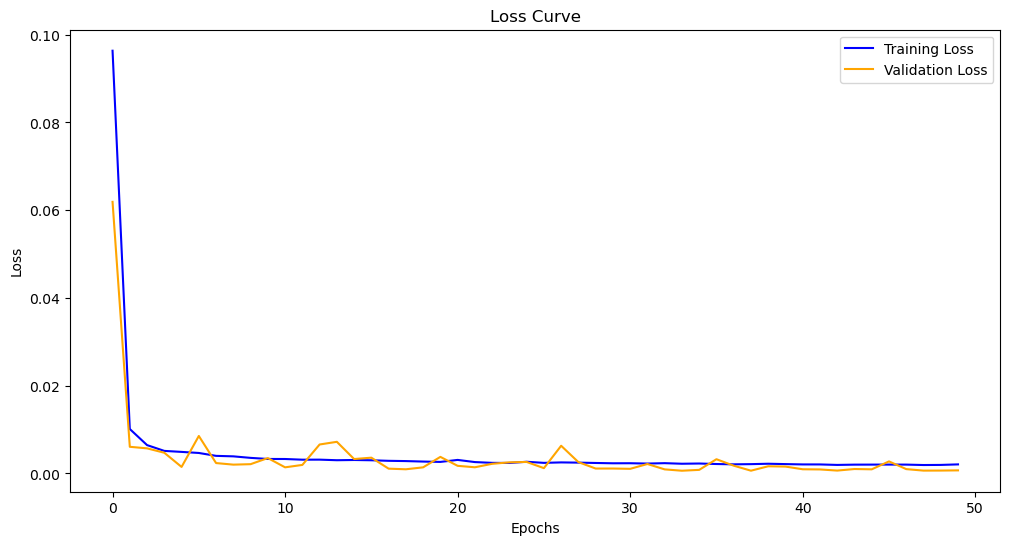

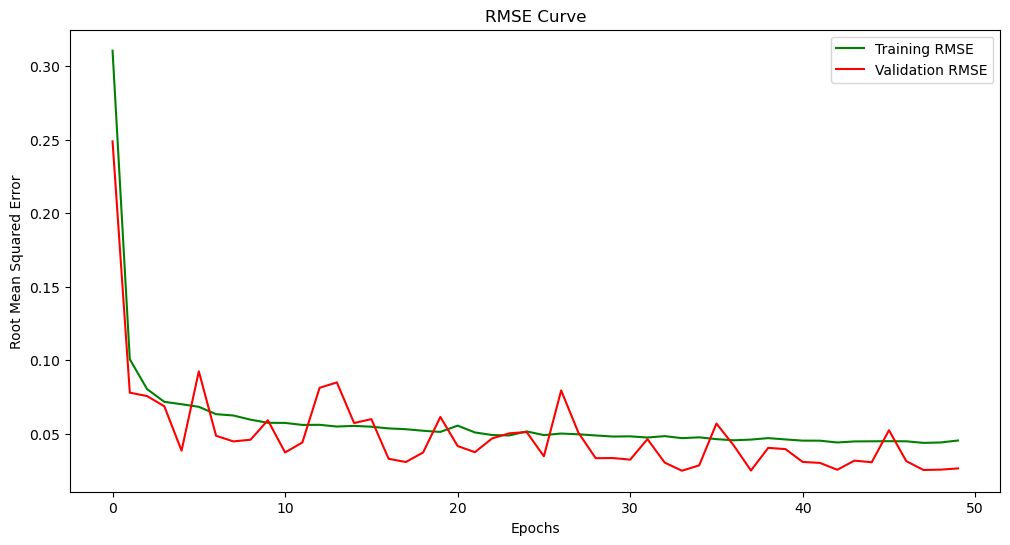

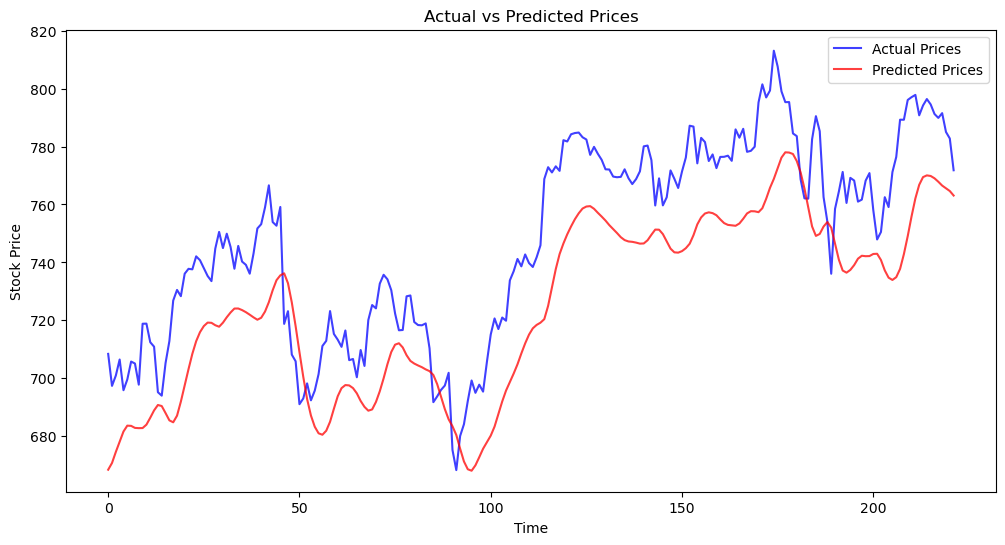

In [59]:
# loading the stock_test dataset
data = stock_train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  # Use the last 60 days to predict the next day
x, y = create_sequences(scaled_data, sequence_length)

split_index = int(len(data) * 0.8)

# Split the array
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

model = Sequential([
       LSTM(64, return_sequences=True, input_shape=(sequence_length, x.shape[2])),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(30, activation='relu'),
        Dense(5)  # Output size matches the number of stock features
    ])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test),verbose=1)

# Evaluate the model
loss,rmse = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, RMSE:{rmse}')

# Make predictions
predictions = model.predict(x_test)

# Rescale predictions back to original scale
three_L_predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

three_L_train_loss = history.history['loss']
three_L_val_loss = history.history['val_loss']
three_L_train_rmse = history.history['root_mean_squared_error']
three_L_val_rmse = history.history['val_root_mean_squared_error']

# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(three_L_train_loss, label='Training Loss', color='blue')
plt.plot(three_L_val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE curve
plt.figure(figsize=(12, 6))
plt.plot(three_L_train_rmse, label='Training RMSE', color='green')
plt.plot(three_L_val_rmse, label='Validation RMSE', color='red')
plt.title('RMSE Curve')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

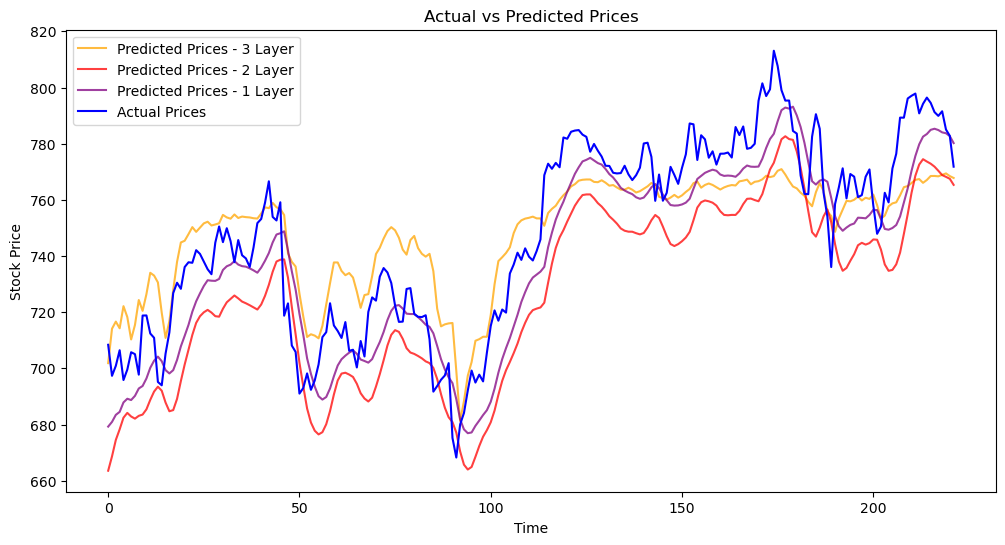

In [30]:
plt.figure(figsize=(12, 6))
one_layer_predictions_rescaled
plt.plot(three_L_predictions_rescaled[:, 3], color='orange', label='Predicted Prices - 3 Layer', alpha=0.75)
plt.plot(two_layer_predictions_rescaled[:, 3], color='red', label='Predicted Prices - 2 Layer', alpha=0.75)
plt.plot(one_layer_predictions_rescaled[:, 3], color='purple', label='Predicted Prices - 1 Layer', alpha=0.75)
plt.plot(two_layer_y_test_rescaled[:, 3], color='blue', label='Actual Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [79]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def objective(trial):
    # Define the model
    num_layers = trial.suggest_int('num_layers', 0, 3)  # Number of LSTM layers (can be 1 to 3 layers)
    units = trial.suggest_int("units", 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  # Dropout rate
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Batch size

    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    for i in range(1, num_layers-1):
        model.add(LSTM(units=units, return_sequences=True))
    model.add(LSTM(units=units, return_sequences=False))  # Final LSTM layer does not return sequences
    model.add(Dropout(dropout_rate))
    model.add(Dense(5))
    
    # Compile the model
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"],
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=25,
        batch_size=32,
        verbose=0,
    )
    
    # Return the validation loss for this trial
    return history.history["val_loss"][-1]

# Create an Optuna study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)


[I 2024-12-07 16:36:29,669] A new study created in memory with name: no-name-a2c9790c-88a4-4d45-aa8d-9cd169c9828b
[I 2024-12-07 16:37:50,116] Trial 0 finished with value: 0.0027810847386717796 and parameters: {'num_layers': 2, 'units': 73, 'dropout_rate': 0.4090393241508429, 'batch_size': 37, 'optimizer': 'adam', 'learning_rate': 0.00047100624232092656}. Best is trial 0 with value: 0.0027810847386717796.
[I 2024-12-07 16:40:17,362] Trial 1 finished with value: 0.21880675852298737 and parameters: {'num_layers': 3, 'units': 57, 'dropout_rate': 0.3393958523011285, 'batch_size': 24, 'optimizer': 'sgd', 'learning_rate': 0.0006337679111748534}. Best is trial 0 with value: 0.0027810847386717796.
[I 2024-12-07 16:41:38,518] Trial 2 finished with value: 0.4455621540546417 and parameters: {'num_layers': 0, 'units': 58, 'dropout_rate': 0.4631734894986993, 'batch_size': 27, 'optimizer': 'sgd', 'learning_rate': 0.00013576616720168555}. Best is trial 0 with value: 0.0027810847386717796.
[I 2024-12-0

Best hyperparameters: {'num_layers': 0, 'units': 64, 'dropout_rate': 0.47113071521656613, 'batch_size': 48, 'optimizer': 'rmsprop', 'learning_rate': 0.004827762868425334}


7/7 [==============================] - 0s 12ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500
Test Loss: 0.0024987231008708477, RMSE:0.049987226724624634
7/7 [==============================] - 1s 13ms/step


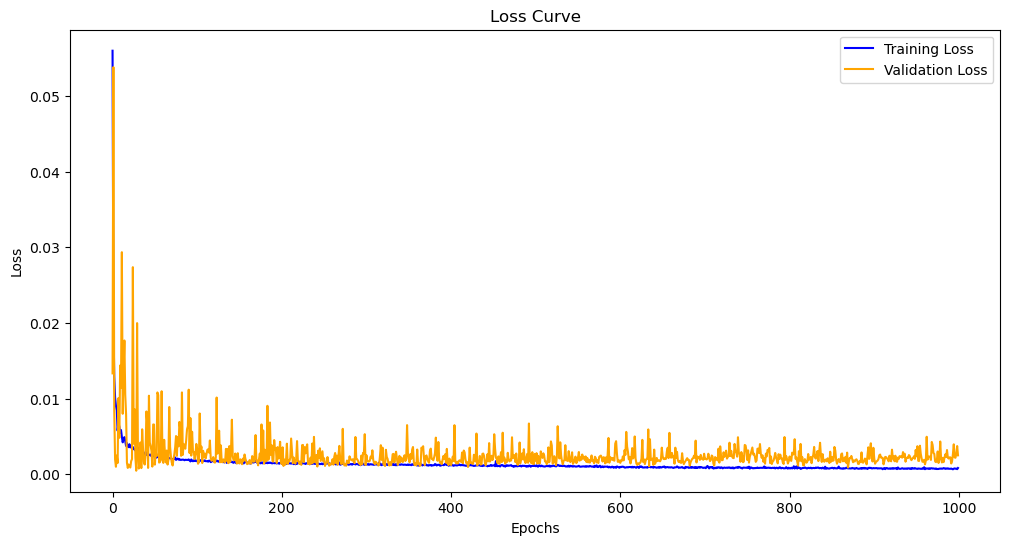

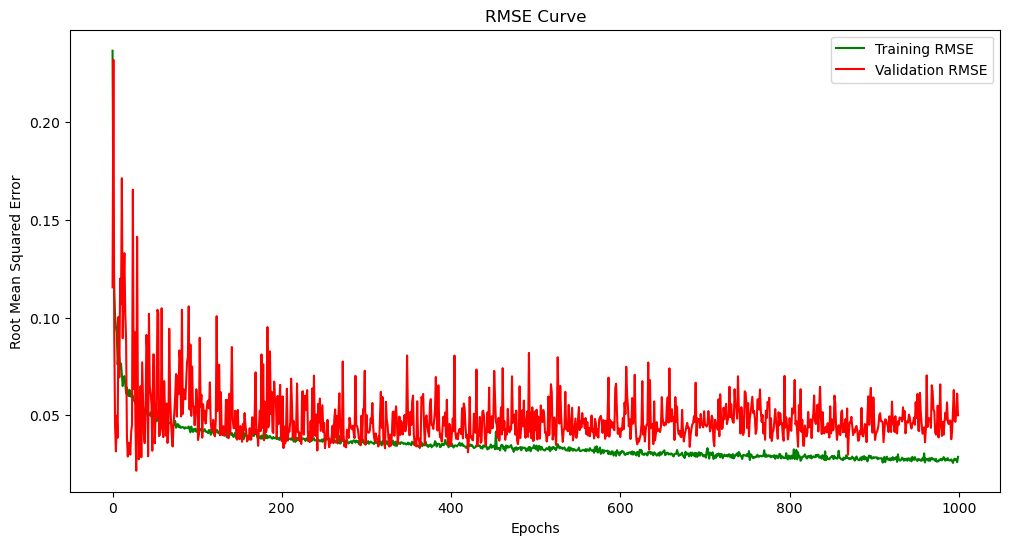

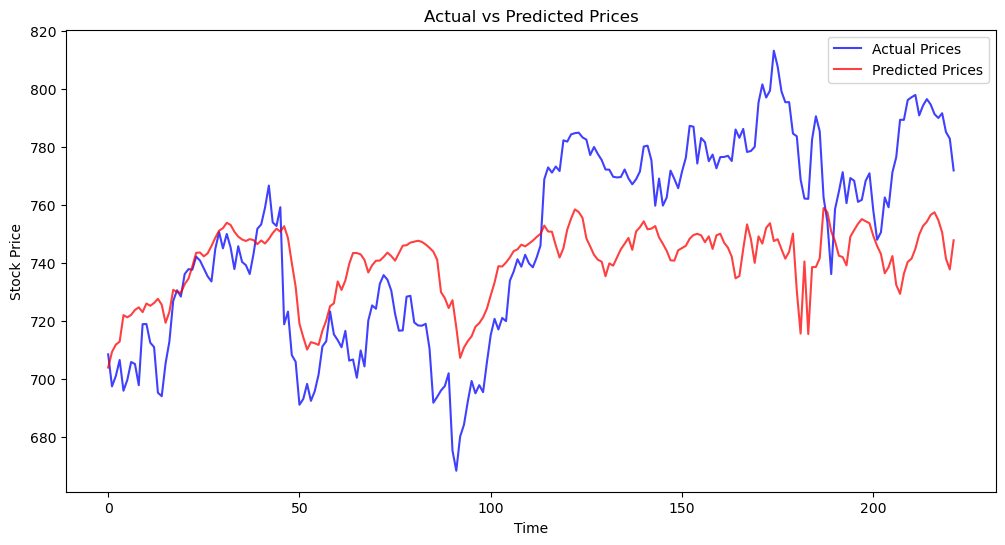

In [13]:
# loading the stock_test dataset
data = stock_train_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  
x, y = create_sequences(scaled_data, sequence_length)

split_index = int(len(data) * 0.8)

# Split the array
x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

model = Sequential([
       LSTM(64, return_sequences=True, input_shape=(sequence_length, x.shape[2])),
        Dropout(0.47),
        LSTM(64, return_sequences=False),
        Dropout(0.47),
        Dense(30, activation='relu'),
        Dense(5)  
    ])
# Compile the model
optimizer = tf.keras.optimizers.RMSprop(0.0048)

model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x_train, y_train, epochs=1000, batch_size=48, validation_data=(x_test, y_test),verbose=0)

# Evaluate the model
loss,rmse = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, RMSE:{rmse}')

# Make predictions
predictions = model.predict(x_test)

# Rescale predictions back to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot RMSE curve
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Training RMSE', color='green')
plt.plot(val_rmse, label='Validation RMSE', color='red')
plt.title('RMSE Curve')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

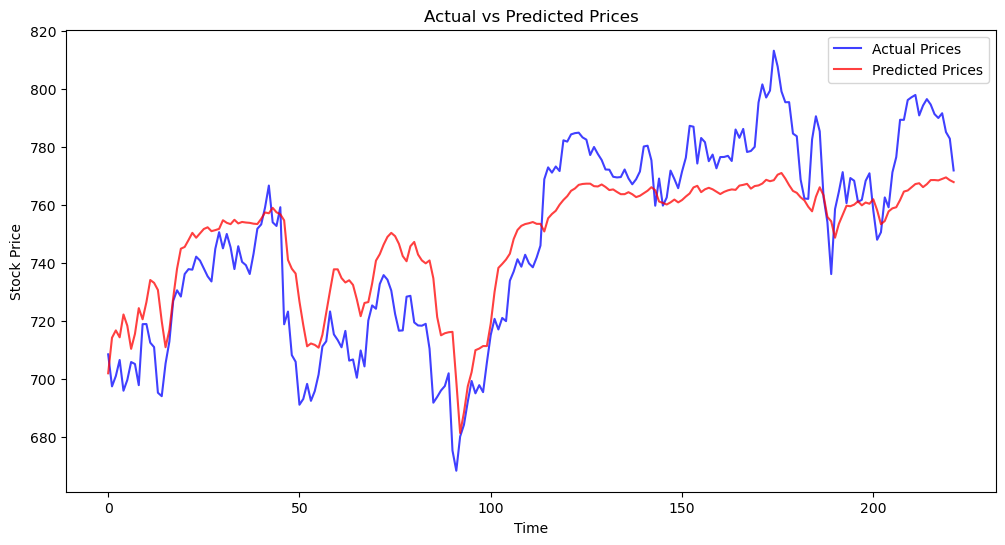

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(three_L_predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [20]:
stock_test_df = pd.read_csv("Google_Stock_Price_Test.csv")


#turn Close field into numeric field
#stock_test_df['Close'] = pd.to_numeric(stock_test_df['Close'].str.replace(',', ''), errors='coerce')

# turn Volume field into numeric field and remove commas 
stock_test_df['Volume'] = stock_test_df['Volume'].str.replace(',', '').astype(int)
stock_test_df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300
1,1/4/2017,788.36,791.34,783.16,786.90,1073000
2,1/5/2017,786.08,794.48,785.02,794.02,1335200
3,1/6/2017,795.26,807.90,792.20,806.15,1640200
4,1/9/2017,806.40,809.97,802.83,806.65,1272400


1/1 [==============================] - 0s 28ms/step


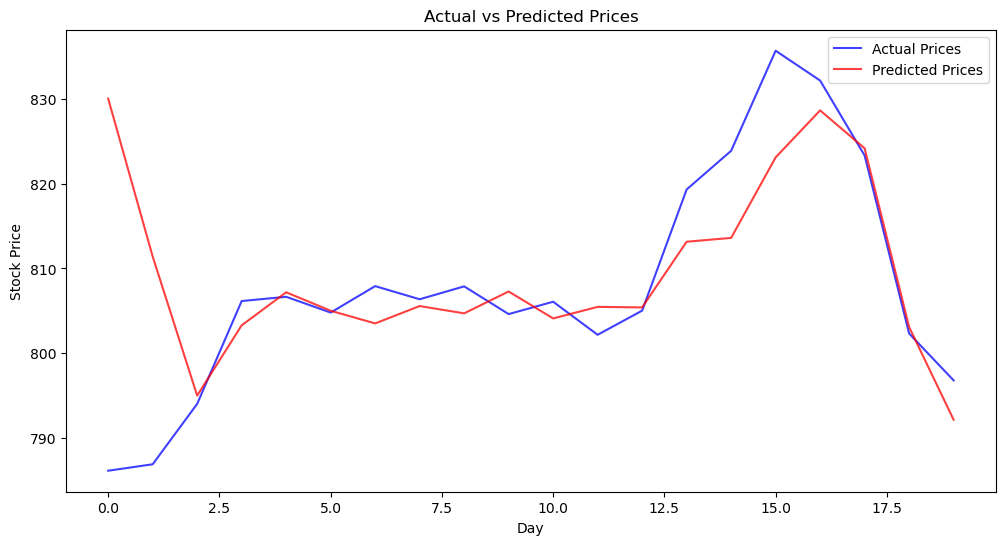

In [23]:
test_data = stock_test_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test_data = scaler.fit_transform(test_data)

#append the last 30 days of the training data to the test_data as basis for prediction
scaled_test_data = np.concatenate((scaled_data[-30:],scaled_test_data), axis=0)


# Create sequences (features and labels)
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30 
x_test, y_test = create_sequences(scaled_test_data, sequence_length)

predictions = model.predict(x_test)

# Rescale predictions back to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], color='blue', label='Actual Prices', alpha=0.75)
plt.plot(predictions_rescaled[:, 3], color='red', label='Predicted Prices', alpha=0.75)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()